##Bi-Variate Techniques

### Methods
- `crosstab`: for both categorical independent and dependent variables
- `t-test` for dichotomous categorical independent and continuous dependent variables
- `anova` for many categorical independent and continuous dependent variables
- `correlate` for both continuous independent and dependent variables


In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
library(tidyverse)
library(dplyr)
library(readr)
df <- readr::read_csv("diamonds.csv")
df$carat01 <- as.numeric(df$carat >= 1)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
New names:
• `` -> `...1`
Rows: 53940 Columns: 11
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): cut, color, clarity
dbl (8): ...1, carat, depth, table, price, x, y, z

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
%%R
head(df,3)

# A tibble: 3 × 12
   ...1 carat cut     color clarity depth table price     x     y     z carat01
  <dbl> <dbl> <chr>   <chr> <chr>   <dbl> <dbl> <dbl> <dbl> <dbl> <dbl>   <dbl>
1     1  0.23 Ideal   E     SI2      61.5    55   326  3.95  3.98  2.43       0
2     2  0.21 Premium E     SI1      59.8    61   326  3.89  3.84  2.31       0
3     3  0.23 Good    E     VS1      56.9    65   327  4.05  4.07  2.31       0


In [4]:
import pandas as pd
import numpy as np
df = pd.read_csv("diamonds.csv")
df["carat01"] = np.where(df["carat"]>=1, 1,0)

In [5]:
df.head(3)

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z,carat01
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43,0
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31,0
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31,0


### 1. Comparing  Qualitative Independent - Qualitative Dependent


#### - Crosstab

##### R

Are `cut` and `carat` independent of eachother? In other words, does the average quality of a diamond diminish with the increase in size?

In [9]:
%%R
gb <- df %>%
  group_by(cut, carat01) %>%
  summarise(num_records=n())

head(gb, 20)

`summarise()` has grouped output by 'cut'. You can override using the `.groups`
argument.
# A tibble: 10 × 3
# Groups:   cut [5]
   cut       carat01 num_records
   <chr>       <dbl>       <int>
 1 Fair            0         793
 2 Fair            1         817
 3 Good            0        2994
 4 Good            1        1912
 5 Ideal           0       15681
 6 Ideal           1        5870
 7 Premium         0        7600
 8 Premium         1        6191
 9 Very Good       0        7812
10 Very Good       1        4270


In [10]:
%%R
#-- Tidyverse
#- Groupby
gb <- df %>%
  group_by(cut, carat01) %>%
  summarise(num_records=n())

#- Pivot
piv <- gb %>%
  pivot_wider(
    names_from = carat01,
    values_from = num_records
  )
piv

`summarise()` has grouped output by 'cut'. You can override using the `.groups`
argument.
# A tibble: 5 × 3
# Groups:   cut [5]
  cut         `0`   `1`
  <chr>     <int> <int>
1 Fair        793   817
2 Good       2994  1912
3 Ideal     15681  5870
4 Premium    7600  6191
5 Very Good  7812  4270


In [11]:
%%R
piv$total <- piv["0"] + piv["1"]
piv["0"] <- piv["0"] / piv$total
piv["1"] <- piv["1"] / piv$total
print(piv[c(1,2,5,3,4),])

# A tibble: 5 × 4
# Groups:   cut [5]
  cut         `0`   `1` total$`0`
  <chr>     <dbl> <dbl>     <int>
1 Fair      0.493 0.507      1610
2 Good      0.610 0.390      4906
3 Very Good 0.647 0.353     12082
4 Ideal     0.728 0.272     21551
5 Premium   0.551 0.449     13791


##### Python

In [ ]:
piv = df.groupby(["cut", "carat01"])["carat"].count().reset_index().rename(columns={"carat":"num_records"})
piv = piv.pivot(index="cut", columns="carat01", values="num_records")
piv.head()

carat01,0,1
cut,,
Fair,793,817
Good,2994,1912
Ideal,15681,5870
Premium,7600,6191
Very Good,7812,4270


In [ ]:
piv = piv.div(piv.sum(axis=1), axis=0) * 100
piv.iloc[[0,1,4,2,3],:]

carat01,0,1
cut,,
Fair,49.254658,50.745342
Good,61.027313,38.972687
Very Good,64.658169,35.341831
Ideal,72.762285,27.237715
Premium,55.108404,44.891596


### 2. Comparing Qualitative Independent - Quantitative Dependent

#### - T-Test
`Is there a statistically significantly difference in the ADR between cancelations and non-cancelations?`

##### R

- [R - Test](https://www.rdocumentation.org/packages/stats/versions/3.6.2/topics/t.test)
- [General T-Test](https://opentextbc.ca/researchmethods/chapter/some-basic-null-hypothesis-tests/#:~:text=The%20Independent%2DSamples%20t%20Test,-The%20independent%2Dsamples&text=The%20null%20hypothesis%20is%20that%20the%20means%20of%20the%20two,goes%20in%20a%20particular%20direction.)

T-test was first described by William Sealy Gosset in 1908, when he published his article under the pseudonym 'student' while working for a brewery. In simple terms, a Student's t-test is a ratio that quantifies how significant the difference is between the `means` of two groups while taking their `variance` or distribution into account.

$$
  t = \frac{M_{1} - M_{2}}{^2\sqrt{\frac{SD_{1} ^2} {n_{1}}\ + \frac{SD_{2}^2}{n_{2}}} }\
$$

null hypothesis: $$\mu_{1} = \mu_{2}$$
alternative hypothesis: $$\mu_{1} \neq \mu_{2}$$

Reject null hypothesis if `p-value` is less than .05. (*or whatever test of significance you prefer*)


In [12]:
%%R
#-- Tidyverse
#- Groupby
gb <- df %>%
  group_by(carat01) %>%
  summarise(avg_price = mean(price, na.rm=TRUE))
gb

# A tibble: 2 × 2
  carat01 avg_price
    <dbl>     <dbl>
1       0     1633.
2       1     8142.


In this case, we can see that `diamonds with greater than 1 carat have higher mean prices`, but this is less meaningful without understanding the variance in both datasets.

In [13]:
%%R
t.test(price ~ carat01, data=df,
       var.equal=TRUE,
       conf.level=0.95)


	Two Sample t-test

data:  price by carat01
t = -289.45, df = 53938, p-value < 2.2e-16
alternative hypothesis: true difference in means between group 0 and group 1 is not equal to 0
95 percent confidence interval:
 -6553.552 -6465.395
sample estimates:
mean in group 0 mean in group 1 
       1632.641        8142.115 



The p-value is way less than 0.05, so we can `reject our null hypothesis` and determine that the `price is statistically different` for diamonds larger than 1 carat

##### Python

In [14]:
from scipy import stats

In [16]:
carat01 = df.loc[df["carat01"] ==1, "price"]
carat00 = df.loc[df["carat01"] ==0, "price"]

In [17]:
t_stat, p_value = stats.ttest_ind(carat00, carat01)
print("Mean pop 1: ", carat00.mean())
print("Mean pop 2: ", carat01.mean())
print("t-statistic:", t_stat)
print("p-value:", p_value)

Mean pop 1:  1632.6408256880734
Mean pop 2:  8142.11463798531
t-statistic: -289.4510178682099
p-value: 0.0


#### - ANOVA - Analysis of Variance
Do the different `cut` ratings have statistically different `prices`?

When there are more than `two groups or condition means to be compared`, the most common null hypothesis test is the analysis of variance (`ANOVA`)

`null hypothesis`: $$\mu_{a} = \mu_{b} = \mu_{c} = \mu_{d}$$
`alternative hypothesis`:     at least 1 group is statistically different from the baseline group

Reject null hypothesis if `p-value` is less than .05. (*or whatever test of significance you prefer*)

The one-way ANOVA is used to compare the means of more than two samples (*M1*, *M2*…*MG*) in a between-subjects design. The null hypothesis is that all the means are equal in the population: `µ1= µ2 =…= µG`. The alternative hypothesis is that not all the means in the population are equal.

##### R

https://statsandr.com/blog/anova-in-r/

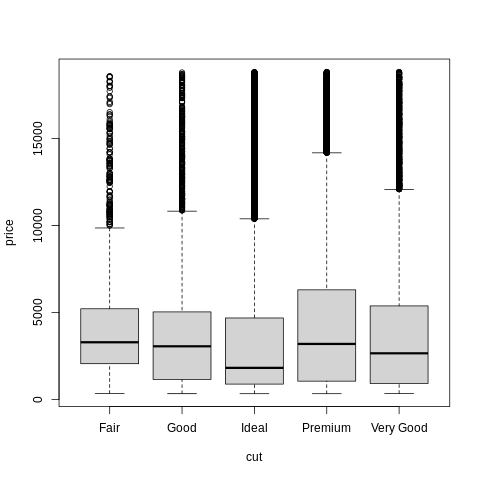

In [18]:
%%R
boxplot(price~cut, data=df)

As you can see, there are 4 groups within `cut`. It appears the `Premium` cut has a higher mean price, but is it statistically significant?

In [19]:
%%R
adr_aov <- aov(price~cut, data=df)
summary(adr_aov)

               Df    Sum Sq   Mean Sq F value Pr(>F)    
cut             4 1.104e+10 2.760e+09   175.7 <2e-16 ***
Residuals   53935 8.474e+11 1.571e+07                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


The ANOVA results indicate that at least one of the `3 groups` is statistically different than the baseline group

...   But which groups? Or all groups?

##### Python

In [20]:
from scipy.stats import f_oneway
print(df["cut"].value_counts())

cut
Ideal        21551
Premium      13791
Very Good    12082
Good          4906
Fair          1610
Name: count, dtype: int64


In [21]:
ideal = df.loc[df["cut"]=="Ideal", "price"]
prem = df.loc[df["cut"]=="Premium", "price"]
v_good = df.loc[df["cut"]=="Very Good", "price"]
good = df.loc[df["cut"]=="Good", "price"]
fair = df.loc[df["cut"]=="Fair", "price"]

In [22]:
f_oneway(ideal, prem, v_good, good, fair)

F_onewayResult(statistic=175.68871735080606, pvalue=8.42830730759452e-150)

### Pairwise t-test

##### R

In [23]:
%%R
pairwise.t.test(df$price,df$cut, p.adjust.method = "holm")


	Pairwise comparisons using t tests with pooled SD 

data:  df$price and df$cut 

          Fair    Good    Ideal   Premium
Good      0.00064 -       -       -      
Ideal     < 2e-16 2.9e-13 -       -      
Premium   0.06154 < 2e-16 < 2e-16 -      
Very Good 0.00101 0.43055 < 2e-16 < 2e-16

P value adjustment method: holm 


Now we can conclude, that all cut values are statistically different than each other except `Fair-Premium` and `Good-Very Good`

In [ ]:
%%R
#------ Couldnt get this to work on Colab!!!

install.packages("ggstatsplot")
install.packages("Rmpfr")
library(ggstatsplot)
#df_ <- dplyr::filter(df, adr <1000)

ggbetweenstats(
  data = df,
  x = cut,
  y = price,
  type = "ANOVA", # ANOVA or Kruskal-Wallis or parametric
  var.equal = TRUE, # ANOVA or Welch ANOVA
  plot.type = "box",
  pairwise.comparisons = TRUE,
  pairwise.display = "significant",
  centrality.plotting = FALSE,
  bf.message = FALSE
)

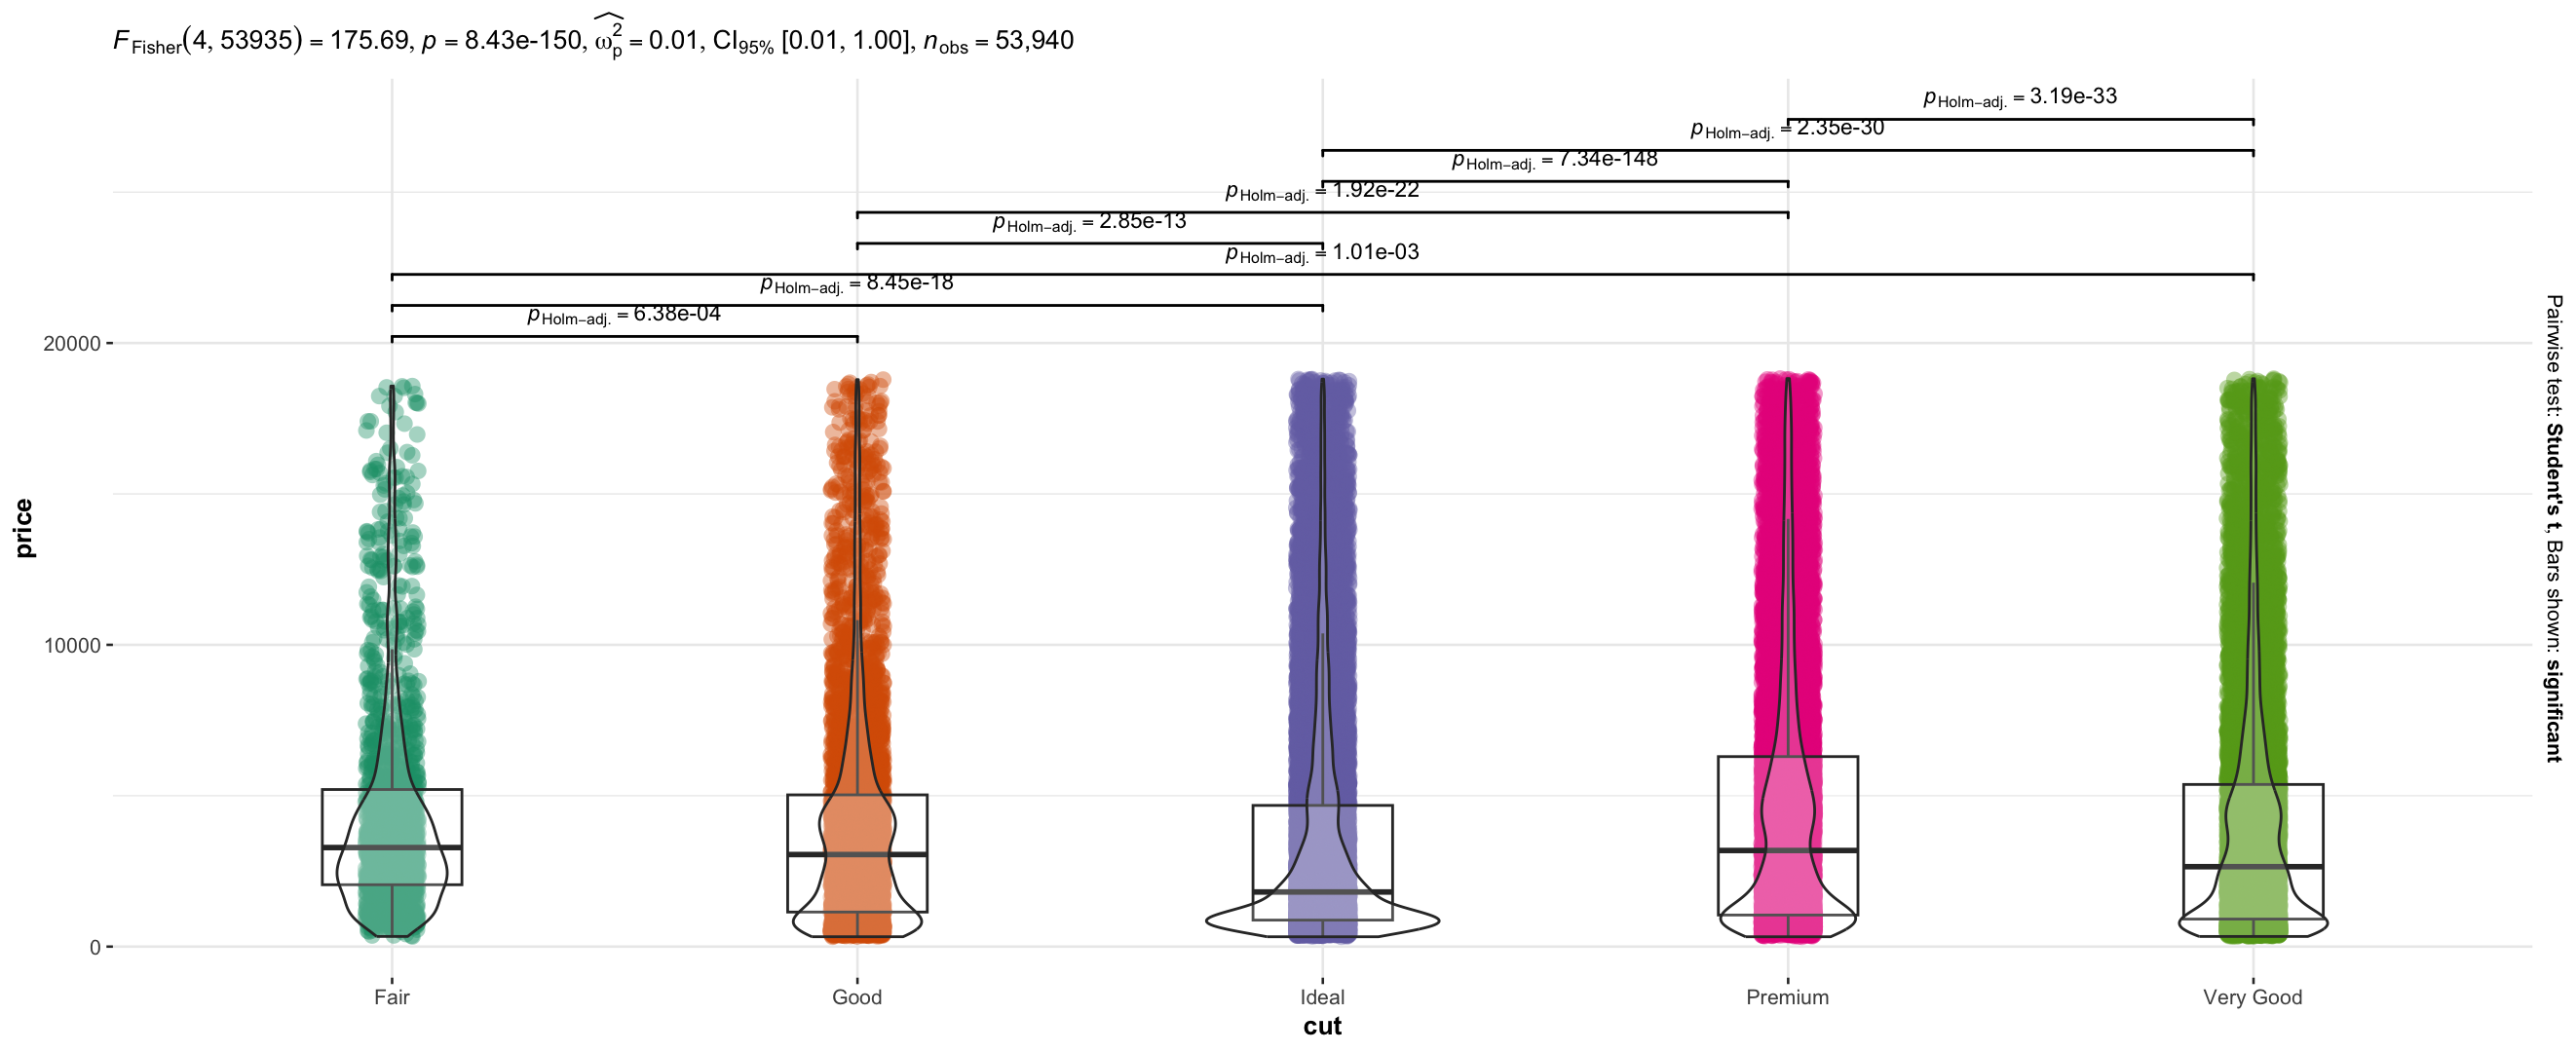

##### Python

In [24]:
from scipy import stats

In [25]:
ideal = df.loc[df["cut"]=="Ideal", "price"]
prem = df.loc[df["cut"]=="Premium", "price"]
v_good = df.loc[df["cut"]=="Very Good", "price"]
good = df.loc[df["cut"]=="Good", "price"]
fair = df.loc[df["cut"]=="Fair", "price"]

In [27]:
vals = ["Ideal", "Premium", "Very Good", "Good", "Fair"]
pairwise_t_test = pd.DataFrame(columns=vals, index=vals)
pairwise_t_test.head()

,Ideal,Premium,Very Good,Good,Fair
Ideal,NaN,NaN,NaN,NaN,NaN
Premium,NaN,NaN,NaN,NaN,NaN
Very Good,NaN,NaN,NaN,NaN,NaN
Good,NaN,NaN,NaN,NaN,NaN
Fair,NaN,NaN,NaN,NaN,NaN


In [28]:
for val1 in vals:
  for val2 in vals:
    t_stat, p_value = stats.ttest_ind(df.loc[df["cut"]==val1, "price"], df.loc[df["cut"]==val2, "price"])
    pairwise_t_test.loc[val1, val2] = p_value
pairwise_t_test.head()

,Ideal,Premium,Very Good,Good,Fair
Ideal,1.0,0.0,0.0,0.0,0.0
Premium,0.0,1.0,0.0,0.0,0.045141
Very Good,0.0,0.0,1.0,0.418765,0.000264
Good,0.0,0.0,0.418765,1.0,0.000042
Fair,0.0,0.045141,0.000264,0.000042,1.0


Why are these results slightly different than the R results? Might it have something to do with the Holm P-value adjustment in the R code?

###3. Comparing Quantitative Independent - Quantitative Dependent

https://sphweb.bumc.bu.edu/otlt/MPH-Modules/PH717-QuantCore/PH717-Module9-Correlation-Regression/PH717-Module9-Correlation-Regression4.html

The equations below show the calculations sed to compute `r`, the `correlation coefficient`. However, you do not need to remember these equations. We will use R to do these calculations for us. Nevertheless, the equations give a sense of how "r" is computed.
$$
  r = \frac{COV(X, Y)}{^2\sqrt{S_{x}^2 \times S_{y}^2}}\
$$

### How to interpret correlation?

 | Correlation Coefficient (r) | 	Description (Rough Guideline ) |
|:--------:|:--------:|
| +1.0	      |Perfect positive + association|
|+0.8 to 1.0	|Very strong + association|
|+0.6 to 0.8	|Strong + association|
|+0.4 to 0.6	|Moderate + association|
|+0.2 to 0.4	|Weak + association|
|0.0 to +0.2	|Very weak + or no association|
|0.0 to -0.2	|Very weak - or no association|
|-0.2 to – 0.4|	Weak - association|
|-0.4 to -0.6	|Moderate - association|
|-0.6 to -0.8	|Strong - association|
|-0.8 to -1.0	|Very strong - association|
|-1.0	        |Perfect negative association|

### Examples of various correlation

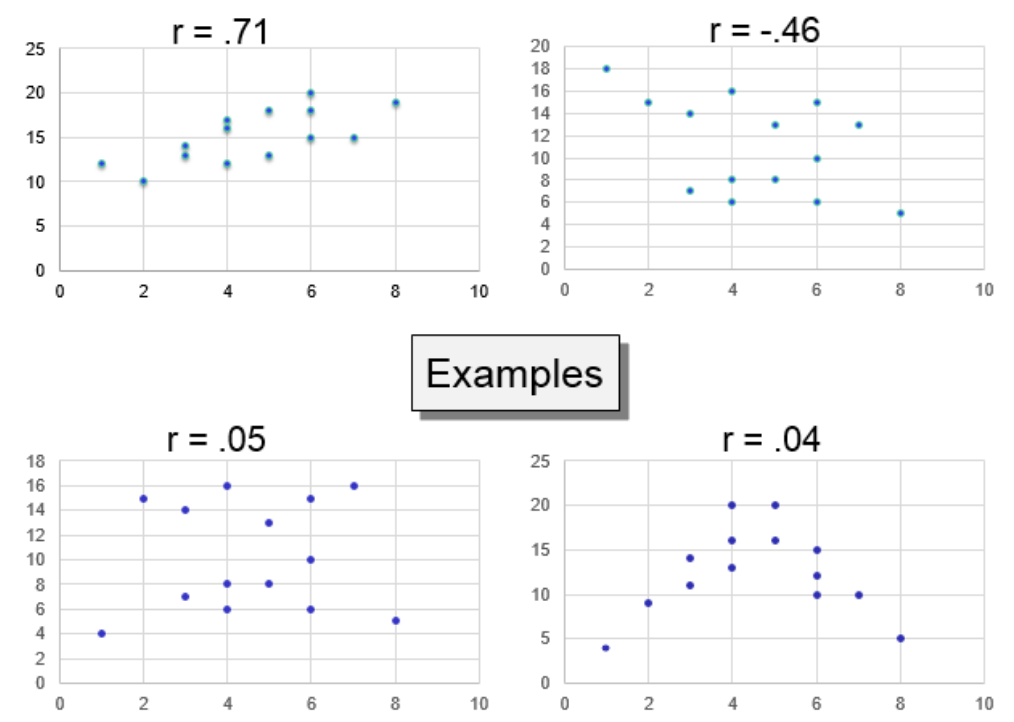

### Correlation can be highly deceiving, use only with the most care!

##### R

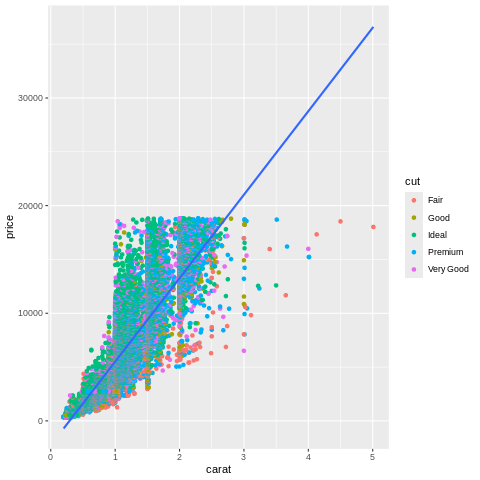

In [ ]:
%%R
ggplot(data=df, mapping=aes(x=carat, y=price)) +
  geom_point(mapping=aes(color=cut)) +
  stat_smooth(method = "lm",
              formula = y ~ x,
              geom = "smooth")

In [29]:
%%R
cor(df$carat, df$price)

[1] 0.9215913


##### Python

In [ ]:
df[["carat", "price"]].corr()

,carat,price
carat,1.000000,0.921591
price,0.921591,1.000000
